In [297]:
import pandas as pd

comments_df = pd.read_csv('KPOP_comments_keyword_and_labels.csv')

In [298]:
sample_df = comments_df.sample(n=2000, random_state=42)
sample_df.to_csv('KPOP_comments_keyword_and_labels_sample.csv', encoding='utf-8-sig', index=False)


In [299]:
df = comments_df[['Group', 'Title', 'date', 'predicted_label']]

In [300]:
# 날짜 형식을 datetime으로 변환
df['date'] = pd.to_datetime(df['date'])

# 특정 그룹만 필터링
group = 'ITZY'

df_group = df[df['Group'] == group]

# 각 그룹별 시간/일간/주간 빈도수 추출
hourly_freq = df_group.groupby(df_group['date'].dt.date).size().reset_index(name='hourly_frequency')
daily_freq = df_group.groupby(df_group['date'].dt.date).size().reset_index(name='daily_frequency')
weekly_freq = df_group.groupby(df_group['date'].dt.isocalendar().week).size().reset_index(name='weekly_frequency')

/var/folders/hw/9m3g7fvn4_l3rp2y473km9sm0000gn/T/ipykernel_19026/639463281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


## 댓글 빈도 시각화

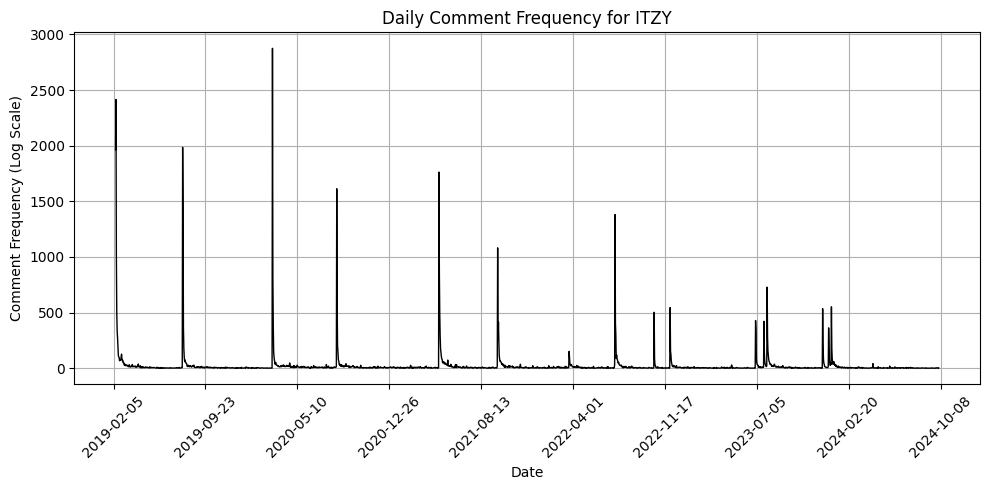

In [301]:
import matplotlib.pyplot as plt
from datetime import timedelta


# 일간 빈도 시각화 (X축을 구간의 1/10 간격으로 표시)
plt.figure(figsize=(10, 5))
plt.plot(daily_freq['date'], daily_freq['daily_frequency'], color='black', linewidth=1)
plt.title(f'Daily Comment Frequency for {group}')
plt.xlabel('Date')
plt.ylabel('Comment Frequency (Log Scale)')
plt.grid(True)

# Y축 로그 스케일 설정
#plt.yscale('log')

# X축 범위를 설정 (최소, 최대 날짜에 padding 추가)
min_date = daily_freq['date'].min() - timedelta(days=5)
max_date = daily_freq['date'].max() + timedelta(days=5)

# X축 눈금 설정 (날짜 범위를 10개 구간으로 설정)
plt.xticks(pd.date_range(start=min_date, end=max_date, periods=10).date, rotation=45)

plt.tight_layout()  # 레이아웃 조정
plt.show()

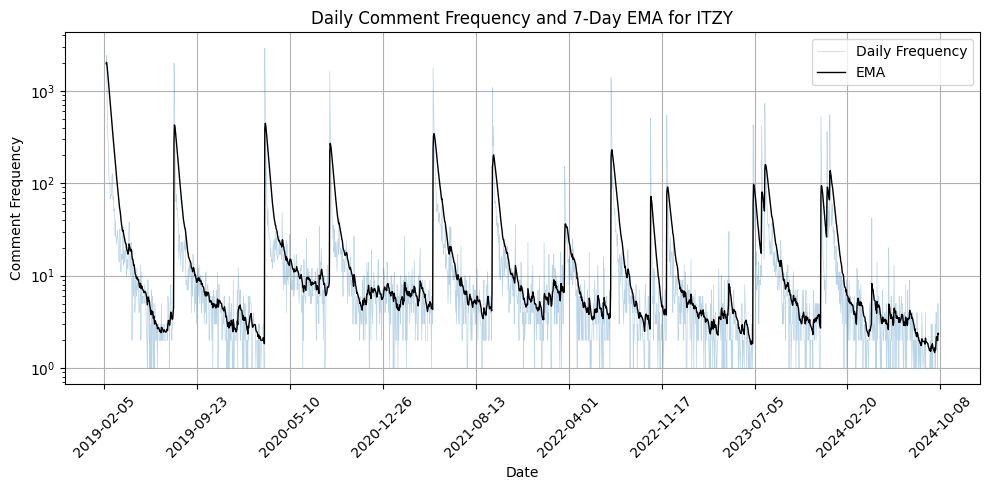

In [302]:
import matplotlib.pyplot as plt
from datetime import timedelta

from scipy.signal import savgol_filter

# 특정 그룹만 필터링
daily_freq['daily_frequency'] = daily_freq['daily_frequency'].replace(0, 1e-6)  # 0을 아주 작은 값으로 대체

# 7일간 지수 가중 이동평균 (EMA) 계산
daily_freq['EMA'] = daily_freq['daily_frequency'].ewm(span=14, adjust=False).mean()

# 7일간 중위수 평활화 (Median Smoothing)
daily_freq['MedianSmoothing'] = daily_freq['daily_frequency'].rolling(window=7, center=True).median()

# SavitzkyGolay 평활화(window_length는 홀수여야 하며, polyorder는 다항식 차수)
daily_freq['SavitzkyGolay'] = savgol_filter(daily_freq['daily_frequency'], window_length=7, polyorder=3)
daily_freq['SavitzkyGolay'] = daily_freq['SavitzkyGolay'].clip(lower=1e-6)  # 1e-6보다 작은 값은 1e-6으로 처리


# 일간 빈도와 7일간 지수 가중 이동평균 시각화
plt.figure(figsize=(10, 5))

# 원래 일간 빈도 시각화
plt.plot(daily_freq['date'], daily_freq['daily_frequency'], label='Daily Frequency', alpha=0.3, linewidth=0.5)

# 7일간 지수 가중 이동평균 시각화
plt.plot(daily_freq['date'], daily_freq['EMA'], color='black',label='EMA', linewidth=1)

# 7일간 중위수 평활화 시각화
#plt.plot(daily_freq['date'], daily_freq['MedianSmoothing'], color='orange', label='Median Smoothing', linewidth=1)

# 사비츠키-골레이필터 시각화
#plt.plot(daily_freq['date'], daily_freq['SavitzkyGolay'], color='purple', label='Savitzky-Golay Filter')

# 그래프 설정
plt.title(f'Daily Comment Frequency and 7-Day EMA for {group}')
plt.xlabel('Date')
plt.ylabel('Comment Frequency')
plt.grid(True)
plt.legend()

# Y축 로그 스케일 설정
plt.yscale('log')

# X축 범위를 설정 (최소, 최대 날짜에 padding 추가)
min_date = daily_freq['date'].min() - timedelta(days=5)
max_date = daily_freq['date'].max() + timedelta(days=5)

# X축 눈금 설정 (날짜 범위를 10개 구간으로 설정)
date_range = pd.date_range(start=min_date, end=max_date, periods=10)
plt.xticks(date_range, date_range.strftime('%Y-%m-%d'), rotation=45)

plt.tight_layout()  # 레이아웃 조정
plt.show()


## 감정비율

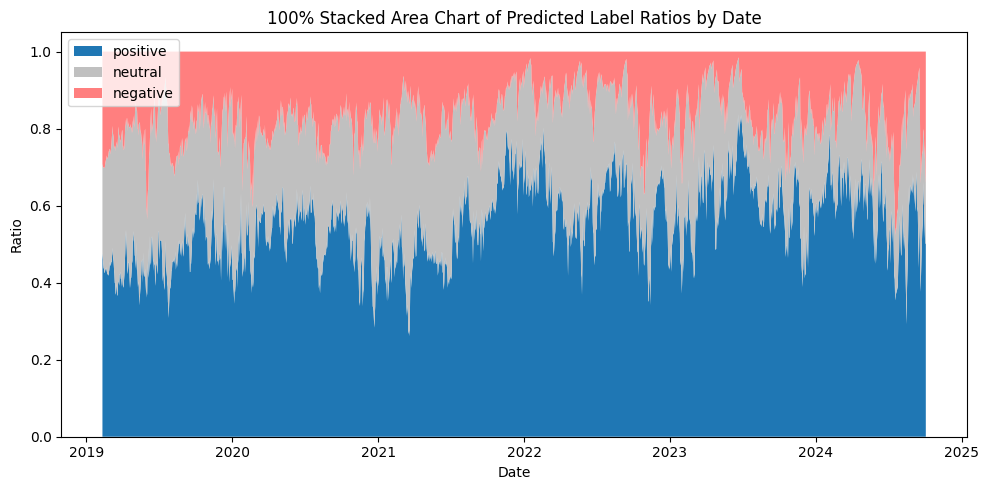

In [303]:

# 특정 그룹만 필터링
#group = 'NewJeans'

df_group = df[df['Group'] == group]

# 다시 일별로 집계하고 'label_0_ratio', 'label_1_ratio', 'label_2_ratio'를 모두 포함하도록 설정
daily_grouped = df_group.groupby(df_group['date'].dt.date)['predicted_label'].value_counts(normalize=True).unstack(fill_value=0)

# 'label_0_ratio', 'label_1_ratio', 'label_2_ratio'로 열 이름을 지정
daily_grouped = daily_grouped.reindex(columns=[0, 1, 2], fill_value=0)
daily_grouped.columns = ['label_0_ratio', 'label_1_ratio', 'label_2_ratio']

# 일별 비율 데이터 준비
daily_grouped.index = pd.to_datetime(daily_grouped.index)  # 날짜 형식을 datetime으로 변환

# 가중 이동 평균(EMA) 적용
#daily_grouped['label_0'] = daily_grouped['label_0_ratio']
#daily_grouped['label_1'] = daily_grouped['label_1_ratio']
#daily_grouped['label_2'] = daily_grouped['label_2_ratio']

daily_grouped['label_0'] = daily_grouped['label_0_ratio'].ewm(span=14, adjust=False).mean()
daily_grouped['label_1'] = daily_grouped['label_1_ratio'].ewm(span=14, adjust=False).mean()
daily_grouped['label_2'] = daily_grouped['label_2_ratio'].ewm(span=14, adjust=False).mean()



# 100% 스택드 에어리어 차트 그리기
plt.figure(figsize=(10, 5))
plt.stackplot(daily_grouped.index, 
              daily_grouped['label_2'], 
              daily_grouped['label_1'], 
              daily_grouped['label_0'], 
              labels=['positive', 'neutral', 'negative'], 
              colors =  ['#1f77b4', '#c0c0c0', '#ff7f7f'],  # 파랑, 회색, 연한 빨강
              edgecolor='none')

# 그래프 제목과 레이블 설정
plt.title('100% Stacked Area Chart of Predicted Label Ratios by Date')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend(loc='upper left')

# 레이아웃 조정 및 그래프 표시
plt.tight_layout()
plt.show()


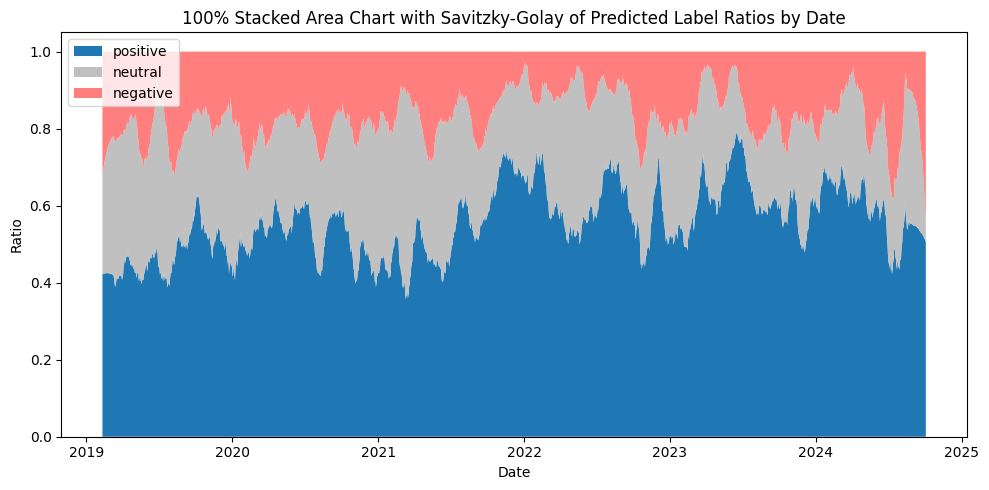

In [304]:
from scipy.signal import savgol_filter

# 특정 그룹만 필터링
#group = 'NewJeans'
df_group = df[df['Group'] == group]

# 다시 일별로 집계하고 'label_0_ratio', 'label_1_ratio', 'label_2_ratio'를 모두 포함하도록 설정
daily_grouped = df_group.groupby(df_group['date'].dt.date)['predicted_label'].value_counts(normalize=True).unstack(fill_value=0)

# 'label_0_ratio', 'label_1_ratio', 'label_2_ratio'로 열 이름을 지정
daily_grouped = daily_grouped.reindex(columns=[0, 1, 2], fill_value=0)
daily_grouped.columns = ['label_0_ratio', 'label_1_ratio', 'label_2_ratio']

# 일별 비율 데이터 준비
daily_grouped.index = pd.to_datetime(daily_grouped.index)  # 날짜 형식을 datetime으로 변환

# 사비츠키-골레이 필터 적용
daily_grouped['label_0_sg'] = savgol_filter(daily_grouped['label_0_ratio'], window_length=55, polyorder=2)
daily_grouped['label_1_sg'] = savgol_filter(daily_grouped['label_1_ratio'], window_length=55, polyorder=2)
daily_grouped['label_2_sg'] = savgol_filter(daily_grouped['label_2_ratio'], window_length=55, polyorder=2)

# 사비츠키-골레이 필터 적용 후 클리핑 (0과 1 사이로 제한)
daily_grouped['label_0_sg'] = daily_grouped['label_0_sg'].clip(0, 1)
daily_grouped['label_1_sg'] = daily_grouped['label_1_sg'].clip(0, 1)
daily_grouped['label_2_sg'] = daily_grouped['label_2_sg'].clip(0, 1)

# 정규화 과정 추가 (비율 합이 1이 되도록 정규화)
total_sg = daily_grouped[['label_0_sg', 'label_1_sg', 'label_2_sg']].sum(axis=1)
daily_grouped['label_0_sg'] = daily_grouped['label_0_sg'] / total_sg
daily_grouped['label_1_sg'] = daily_grouped['label_1_sg'] / total_sg
daily_grouped['label_2_sg'] = daily_grouped['label_2_sg'] / total_sg

# 100% 스택드 에어리어 차트 그리기 (사비츠키-골레이 필터 적용 후)
plt.figure(figsize=(10, 5))
plt.stackplot(daily_grouped.index, 
              daily_grouped['label_2_sg'], 
              daily_grouped['label_1_sg'], 
              daily_grouped['label_0_sg'], 
              labels=['positive', 'neutral', 'negative'], 
              colors =  ['#1f77b4', '#c0c0c0', '#ff7f7f'],  # 파랑, 회색, 연한 빨강
              edgecolor='none')

# 그래프 제목과 레이블 설정
plt.title('100% Stacked Area Chart with Savitzky-Golay of Predicted Label Ratios by Date')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend(loc='upper left')

# 레이아웃 조정 및 그래프 표시
plt.tight_layout()
plt.show()


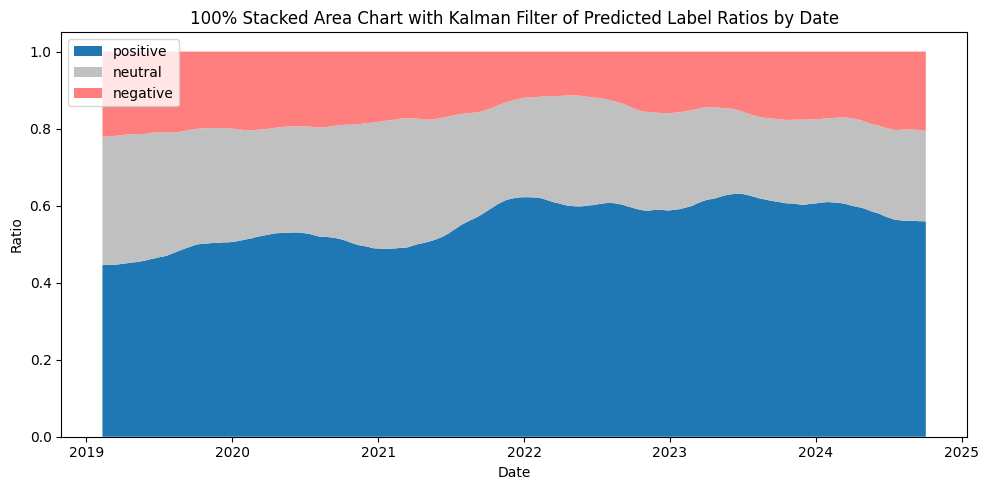

In [305]:
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# 칼만필터 객체와 Q와 R을 설정 (여기서 Q는 프로세스 잡음, R은 관측 잡음)
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
kf.transition_covariance = np.array([[1e-6]])  # Q값
kf.observation_covariance = np.array([[1e-2]])  # R값


# 각 레이블 비율에 칼만 필터 적용
#daily_grouped['label_0_kf'] = kalman_filter(daily_grouped['label_0_ratio'].values)
#daily_grouped['label_1_kf'] = kalman_filter(daily_grouped['label_1_ratio'].values)
#daily_grouped['label_2_kf'] = kalman_filter(daily_grouped['label_2_ratio'].values)

daily_grouped['label_0_kf'] = kf.smooth(daily_grouped['label_0_ratio'])[0].flatten()
daily_grouped['label_1_kf'] = kf.smooth(daily_grouped['label_1_ratio'])[0].flatten()
daily_grouped['label_2_kf'] = kf.smooth(daily_grouped['label_2_ratio'])[0].flatten()

# 정규화 과정 추가 (비율 합이 1이 되도록 정규화)
total_kf = daily_grouped[['label_0_kf', 'label_1_kf', 'label_2_kf']].sum(axis=1)
daily_grouped['label_0_kf'] = daily_grouped['label_0_kf'] / total_kf
daily_grouped['label_1_kf'] = daily_grouped['label_1_kf'] / total_kf
daily_grouped['label_2_kf'] = daily_grouped['label_2_kf'] / total_kf

# 100% 스택드 에어리어 차트 그리기 (칼만 필터 적용 후)
plt.figure(figsize=(10, 5))
plt.stackplot(daily_grouped.index, 
              daily_grouped['label_2_kf'], 
              daily_grouped['label_1_kf'], 
              daily_grouped['label_0_kf'], 
              labels=['positive', 'neutral', 'negative'], 
              colors =  ['#1f77b4', '#c0c0c0', '#ff7f7f'],  # 파랑, 회색, 연한 빨강
              edgecolor='none')


# 그래프 제목과 레이블 설정
plt.title('100% Stacked Area Chart with Kalman Filter of Predicted Label Ratios by Date')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend(loc='upper left')

# 레이아웃 조정 및 그래프 표시
plt.tight_layout()
plt.show()


## 일주일 간 시간단위 추이

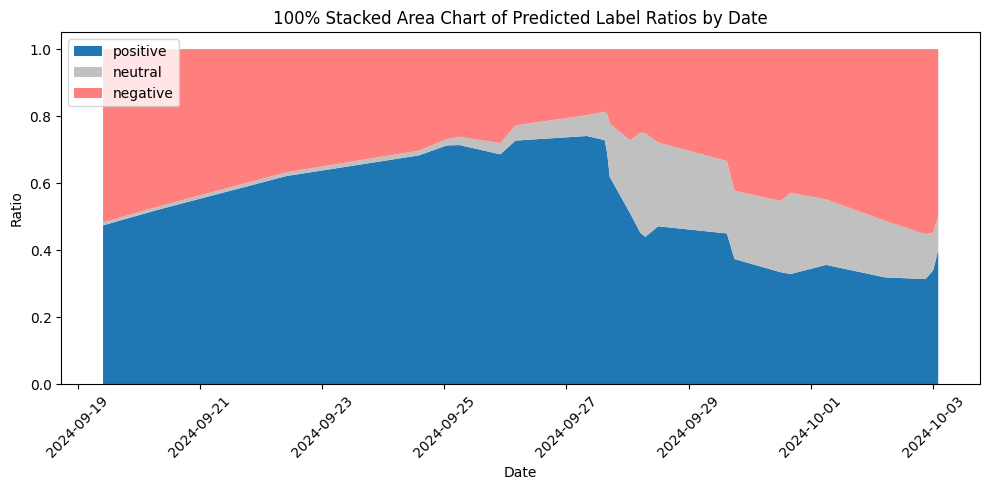

In [310]:
# 특정 그룹만 필터링
#group = 'NewJeans'
df_group = df[df['Group'] == group]

# 현재 시점에서 30일 동안의 데이터만 필터링
end_date = df_group['date'].max()  # 현재 시점
start_date = end_date - pd.Timedelta(days=14)  # 30일 전
df_group = df_group[(df_group['date'] >= start_date) & (df_group['date'] <= end_date)]

# 일별, 시간별로 그룹화
daily_grouped = df_group.groupby(df_group['date'].dt.floor('H'))['predicted_label'].value_counts(normalize=True).unstack(fill_value=0)

# 'label_0_ratio', 'label_1_ratio', 'label_2_ratio'로 열 이름 지정
daily_grouped = daily_grouped.reindex(columns=[0, 1, 2], fill_value=0)
daily_grouped.columns = ['label_0_ratio', 'label_1_ratio', 'label_2_ratio']

# 칼만필터 객체와 Q와 R을 설정 (여기서 Q는 프로세스 잡음, R은 관측 잡음)
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
kf.transition_covariance = np.array([[1e-3]])  # Q값
kf.observation_covariance = np.array([[1e-2]])  # R값

# 각 레이블 비율에 칼만 필터 적용
#daily_grouped['label_0_kf'] = kalman_filter(daily_grouped['label_0_ratio'].values)
#daily_grouped['label_1_kf'] = kalman_filter(daily_grouped['label_1_ratio'].values)
#daily_grouped['label_2_kf'] = kalman_filter(daily_grouped['label_2_ratio'].values)
daily_grouped['label_0_kf'] = kf.smooth(daily_grouped['label_0_ratio'])[0].flatten()
daily_grouped['label_1_kf'] = kf.smooth(daily_grouped['label_1_ratio'])[0].flatten()
daily_grouped['label_2_kf'] = kf.smooth(daily_grouped['label_2_ratio'])[0].flatten()

# 정규화 과정 추가 (비율 합이 1이 되도록 정규화)
total_kf = daily_grouped[['label_0_kf', 'label_1_kf', 'label_2_kf']].sum(axis=1)
daily_grouped['label_0_kf'] = daily_grouped['label_0_kf'] / total_kf
daily_grouped['label_1_kf'] = daily_grouped['label_1_kf'] / total_kf
daily_grouped['label_2_kf'] = daily_grouped['label_2_kf'] / total_kf


# X축 레이블에서 올바른 날짜 형식을 유지할 수 있도록 날짜 변환
daily_grouped.index = pd.to_datetime(daily_grouped.index)

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.stackplot(daily_grouped.index, 
              daily_grouped['label_2_kf'], 
              daily_grouped['label_1_kf'], 
              daily_grouped['label_0_kf'], 
              labels=['positive', 'neutral', 'negative'], 
              colors =  ['#1f77b4', '#c0c0c0', '#ff7f7f'],  # 파랑, 회색, 연한 빨강
              edgecolor='none')

# X축 레이블 및 제목 설정
plt.title('100% Stacked Area Chart of Predicted Label Ratios by Date')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend(loc='upper left')

# X축 날짜 표시 형식 조정
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
